In [1]:
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tools

import warnings,sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

/Users/cengjianhuan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Load data
load_file = '../datasets/reddit_submissions.json'
someposts = pd.read_json(load_file , lines=True)
someposts.index = someposts['id']

# Iterative model development

If don't change the model, I may try:

Hyperparamters Tuning:
+ initial learning rate
+ vocabulary_size: 5000, 10000 for the total stemming 82477 words
+ embedding dimensions: 16, 32, 64, 128, 256 with respect to vocabulary size

Text Processing: 
+ do stemming or not, 
+ with stop word/not
+ make additional features, like:
    + subreddit_type, indicating will the client want to show/express himself
    + local datetime from created_utc, will the client talk in the morning/evening effect. 
    

The training is slow, I don't have time to fully train to evaluate and pick features, so I /**assume**/ the word-level LSTM is the best one and retrain the model. The potential features to use are subreddit_type and local datetime. Since the additional feature are not text, but /**categorical features**/, we can have /** two types of inputs **/ with functional keras API.

In [4]:
# process text to integer
vocabulary_size = 1000
subreddit_mappings, someposts = tools.record_process(someposts, features = ['title', 'selftext','subreddit_type','created_utc'])
index_to_word, X_train  = tools.textprocess(someposts[['title','selftext']].apply(lambda x: 'End. '.join(x), axis=1).values, vocabulary_size)

# partitions the model-ready data into train, validation, and test sets.
print('There are {} records after processing'.format(len(someposts)))
X_train, X_test, X_val, y_train, y_test, y_val = tools.partition_dataset(someposts, X_train)
print('There are {},{},{} records for train, validation, and test sets'.format(len(X_train), len(X_val), len(X_test)))

# Cut texts after this number of words 
max_len = 300
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_val = keras.preprocessing.sequence.pad_sequences(X_val, maxlen=max_len)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)
print(X_train.shape)

There are 236742 records after processing
The sum of rare categories is 1142
Found 120579 unique words tokens.
Using vocabulary size 1000.
The least frequent word in our vocabulary is 'pressur' and appeared 4534 times.

Example sentence: Coping with panic/anxiety attacks. You tips?EndFollowing on from the Onion article, and some suggestions that a discussion would be good, can anyone share their tips for dealing with this?

Example sentence after processing: ['cope', 'with', 'panic', 'anxieti', 'attack', 'you', 'tip', 'UNKNOWN_TOKEN', 'on', 'from', 'the', 'UNKNOWN_TOKEN', 'UNKNOWN_TOKEN', 'and', 'some', 'suggest', 'that', 'a', 'discuss', 'would', 'be', 'good', 'can', 'anyon', 'share', 'their', 'tip', 'for', 'deal', 'with', 'thi']

Example input sentence: [563, 19, 567, 182, 507, 29, 978, 999, 30, 70, 3, 999, 999, 2, 86, 658, 10, 4, 927, 72, 20, 116, 28, 106, 438, 197, 978, 15, 265, 19, 18]
There are 236742 records after processing
There are 189393,23675,23674 records for train, validat

In [2]:
# Restore the model
model = load_model('ModelTraining/partly_trained_lstm_0613.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 16)           80000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_1 (Dense)              (None, 17)                2193      
Total params: 156,433
Trainable params: 156,433
Non-trainable params: 0
_________________________________________________________________


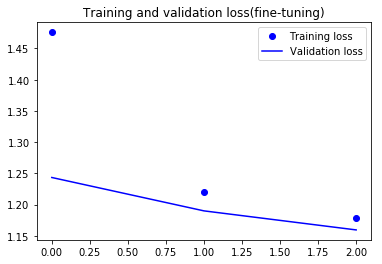

In [7]:
# prepare for training
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', 
                                                  min_delta=0.0001,
                                                  patience=1, 
                                                  verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint('ModelTraining/lstm_1st.hdf5', 
                                             verbose=1, 
                                             save_best_only=True) 

# training
history = model.fit(X_train, y_train, 
                    batch_size = 64,
                    epochs=8, 
                    validation_data=(X_val, y_val),
                    initial_epoch = 5,
                    callbacks=[checkpoint, early_stopping])


# plot the training process
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(fine-tuning)')
plt.legend()

plt.show()

In [9]:
# Evaluation
results = model.predict(X_test)
predictions = results.argmax(axis = 1)
print(classification_report(y_test, predictions))

#Save partly trained model
model.save('ModelTraining/partly_trained_lstm_0613.h5')

             precision    recall  f1-score   support

          0       0.65      0.34      0.45       109
          1       0.64      0.54      0.58      1647
          2       0.64      0.53      0.58      1357
          3       0.55      0.60      0.57       129
          4       0.46      0.12      0.19       680
          5       0.48      0.48      0.48       213
          6       0.62      0.72      0.67      5562
          7       0.74      0.80      0.77       456
          8       0.61      0.72      0.66      9161
          9       0.65      0.24      0.35       267
         10       0.00      0.00      0.00       197
         11       0.38      0.10      0.16       749
         12       0.29      0.10      0.14       104
         13       0.73      0.52      0.61       462
         14       0.64      0.59      0.62       320
         15       0.65      0.44      0.52       991
         16       0.63      0.63      0.63      1270

avg / total       0.61      0.62      0.60  

# Discussion
+ Finally, provide a short discussion comparing the results you found in parts 1 and 2: both parts 1 and 2 are underfitting. We first should run more epochs to train. 
+ The limitations in my methodology is that the model is a /**biased model**/, where later words are more dominant than earlier words. 
+ Promising directions that you think may improve model performance: Currently, my model is /**underfitting**/, I will try to those to make more fit 
    + firstly train enough epochs
    + secondly hyperparamters tuning: more units or more layers
    + may try text processing to make a good dataset(shape the dataset) instead of simply large dataset.
    + tried an advanced RCNN model